In [1]:
!git clone https://github.com/reemashraf/vechileClassification.git

Cloning into 'vechileClassification'...
remote: Enumerating objects: 2539, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 2539 (delta 0), reused 3 (delta 0), pack-reused 2536
Receiving objects: 100% (2539/2539), 843.42 MiB | 26.94 MiB/s, done.
Checking out files: 100% (2532/2532), done.


## install all required libraries 

In [ ]:
!pip install tensorflow
!pip install opencv-python
!pip install keras.models
!pip install keras.layers
!pip install sklearn
!pip install matplotlib
!pip install warnings
!pip install os

## importing used libraries 

In [2]:
import os, cv2
import numpy as np
import tensorflow as tf
from tensorflow.python import keras

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, AvgPool2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from keras import regularizers
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
# paths varibles
data_dir = '/content/vechileClassification/dataset/'
output_dir = '/content/outputImages'
inputVideoPath = '/content/demo.mkv'
testImagesPath =  output_dir+'/testImages/'

## Reading of Data

There is 0 csv file in the current version of the dataset:


In [4]:
def labelingData():
  '''
  description: read the dataset from folder and label them.
  output : images -> numpy array of read dataset 
          car_types -> numpy array that contains each image label
       
  
  '''
  images = []
  car_types = []
  for car_type in ["car","truck" ,"bus"]:
      car_dir = data_dir + car_type
      car_files = [car_dir + '/' + filename for filename in os.listdir(car_dir)]
      for filename in car_files:
          if filename.endswith('jpg'):
              try:
                  images.append(cv2.resize(cv2.imread(filename), (224,224), interpolation=cv2.INTER_CUBIC))
                  car_types.append(car_type)
              except Exception as e:
                  print(str(e))
              
              
  images = np.array(images)
  car_types = np.array(car_types)
  return images , car_types


def labelEncoding(car_types):
  '''
  description: perform one hot encoding to labeled array
  input : car_types -> numpy array that contains each image label
  output: car_types_encoded_onehot -> numpy array that contain one hot encoding ot car_types
  
  '''
  le = LabelEncoder()
  car_types_encoded = le.fit_transform(car_types)
  car_types_encoded_onehot = np_utils.to_categorical(car_types_encoded)
  return car_types_encoded_onehot

In [5]:
def modelCreation():
    model = Sequential()

    model.add(Conv2D(32, (3, 3),input_shape=(224, 224, 3),strides = (1,1),  padding = 'same',kernel_initializer='he_normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(AvgPool2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3),strides = (1,1),  padding = 'same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3),strides = (1,1),  padding = 'same', activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3),strides = (1,1),  padding = 'same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(units=128, activation='relu', kernel_initializer='normal'))
    model.add(Dense(units=3, activation='sigmoid', kernel_initializer='normal'))
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    return model


In [6]:
def dataSplit(images , car_types_encoded_onehot):
  '''
  description :  split the dataset into train and validation with 80:20 and augment and normalize the data 
  input : images , car_types_encoded_onehot
  output : x_train, x_val, y_train, y_val

  '''
  # splitting of data to train and validation 80:20 
  x_train, x_val, y_train, y_val = train_test_split(images, car_types_encoded_onehot, test_size=0.2, random_state=0, stratify=car_types_encoded_onehot)
  # normalization of images 
  x_train = x_train / 255
  x_val = x_val / 255

  # set train Generator which is resonsible for normalization and augmentation of data 
  datagen = ImageDataGenerator(rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True)
  datagen.fit(x_train)
  return x_train, x_val, y_train, y_val , datagen


In [7]:
def train(model , datagen):
    # trainning process
    nb_epoch = 100
    batch_size = 25

    fitted_model = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch = len(x_train)//batch_size,
                        epochs=nb_epoch,
                        validation_data = (x_val, y_val),
                        )
    return model , fitted_model

### Visualization of results 

In [8]:
def accuracyPlot(fitted_model):
    # visualization of train and validation accuracy 
    plt.plot(fitted_model.history['accuracy'])
    plt.plot(fitted_model.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    

In [9]:
def errorPlot(fitted_model):
    # visualization of error decay across training process 
    plt.figure()
    plt.gcf().clear()
    plt.plot(fitted_model.history['loss'])
    plt.plot(fitted_model.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.show()

In [18]:
# getting Frames from videos content
!python3 /videoToImage.py '/content/demo.mkv' '/content/outputImages/testImages'

Creating.../content/outputImages/testImages/0.jpg
Creating.../content/outputImages/testImages/1.jpg
Creating.../content/outputImages/testImages/2.jpg
Creating.../content/outputImages/testImages/3.jpg
Creating.../content/outputImages/testImages/4.jpg
Creating.../content/outputImages/testImages/5.jpg
Creating.../content/outputImages/testImages/6.jpg
Creating.../content/outputImages/testImages/7.jpg
Creating.../content/outputImages/testImages/8.jpg
Creating.../content/outputImages/testImages/9.jpg
Creating.../content/outputImages/testImages/10.jpg
Creating.../content/outputImages/testImages/11.jpg
Creating.../content/outputImages/testImages/12.jpg
Creating.../content/outputImages/testImages/13.jpg
Creating.../content/outputImages/testImages/14.jpg
Creating.../content/outputImages/testImages/15.jpg
Creating.../content/outputImages/testImages/16.jpg
Creating.../content/outputImages/testImages/17.jpg
Creating.../content/outputImages/testImages/18.jpg
Creating.../content/outputImages/testImag

In [10]:
def predict(model):
  '''
  description: read each frame and apply prediction of it 
  input :  model 
  output : predicationClasses: list of tuples that holes prediction and images names
  '''
  classes = []
  imagesName = []
  for f in os.listdir(testImagesPath):
      imagePath = os.path.join(testImagesPath, f)
      img = cv2.imread(imagePath)
      img = cv2.resize(img,(224,224))
      img = np.reshape(img,[1,224,224,3])
      imagesName.append(f)
      classes.append((np.argmax(model.predict(img), axis = -1))[0])
  predicationClasses = list(zip(imagesName , classes))
  # sorting frames as video streams as they are shuffled according to string concatincations 
  predicationClasses.sort(key=lambda x:int(x[0].split(".")[0]))
  return predicationClasses


In [24]:
def foldersCreation():
  '''
  description: check the existance of required folders and create them of needed 
  '''
  if not os.path.exists(output_dir):
    os.makedirs(output_dir)
  
  if not os.path.exists(output_dir +'/car'):
    os.makedirs(output_dir +'/car')
  
  if not os.path.exists(output_dir +'/truck'):
    os.makedirs(output_dir +'/truck')
  
  if not os.path.exists(output_dir +'/bus'):
    os.makedirs(output_dir +'/bus')
 
def savingFrames(predicationClasses):
  '''
  description : saving prediction of frames in their crossponding folders 
  input: predictionClasses -> list of tuples that contain prediction and name of image

  '''
  for i in range(len(predicationClasses)):
    # check wheather current frame is like the following one or not 
    if i != len(predicationClasses)-1 :
      j = i+1
      if predicationClasses[i][1] == predicationClasses[j][1]:
        continue
    imgPath = os.path.join(testImagesPath , predicationClasses[i][0])
    img = cv2.imread(imgPath, 1)

    if predicationClasses[i][1] == 0 : # bus Folder 
      folderName = '/bus'

    elif predicationClasses[i][1] == 1:  # car Folder
      folderName = '/car'

    else:  # truck Folder
      folderName = '/truck'
    # saving the images to folder 
    cv2.imwrite(output_dir +folderName +'/'+ predicationClasses[i][0], img)

def statics():
  '''
  description : get the required statistics counts 
  '''
    # getting count of each class 
  carList = os.listdir(output_dir +'/car')
  carCount = len(carList)

  busList = os.listdir(output_dir +'/bus')
  busCount = len(busList)

  truckList = os.listdir(output_dir +'/truck')
  truckCount = len(truckList)
  print("Total number of each Class : Car = {} , Bus = {} and Truck = {}".format(carCount ,busCount , truckCount ))

In [12]:
images , car_types = labelingData()
car_types_encoded_onehot = labelEncoding(car_types)
# shuffling of data in order to be more really 
images, car_types, car_types_encoded_onehot = shuffle(images, car_types, car_types_encoded_onehot)


In [13]:
model = modelCreation()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 112, 112, 32)     0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                        

Epoch 1/100
80/80 [==============================] - 32s 272ms/step - loss: 1.3772 - accuracy: 0.4662 - val_loss: 1.2768 - val_accuracy: 0.5049
Epoch 2/100
80/80 [==============================] - 20s 256ms/step - loss: 1.2010 - accuracy: 0.5188 - val_loss: 1.1832 - val_accuracy: 0.5108
Epoch 3/100
80/80 [==============================] - 20s 252ms/step - loss: 1.1362 - accuracy: 0.5218 - val_loss: 1.1515 - val_accuracy: 0.5424
Epoch 4/100
80/80 [==============================] - 20s 253ms/step - loss: 1.0431 - accuracy: 0.5593 - val_loss: 1.0062 - val_accuracy: 0.6055
Epoch 5/100
80/80 [==============================] - 20s 255ms/step - loss: 0.9870 - accuracy: 0.5928 - val_loss: 0.9365 - val_accuracy: 0.6213
Epoch 6/100
80/80 [==============================] - 20s 254ms/step - loss: 0.9538 - accuracy: 0.5978 - val_loss: 0.8959 - val_accuracy: 0.6746
Epoch 7/100
80/80 [==============================] - 20s 255ms/step - loss: 0.8802 - accuracy: 0.6478 - val_loss: 0.7535 - val_accuracy:

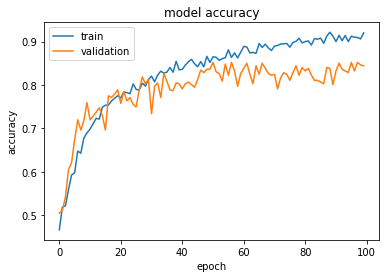

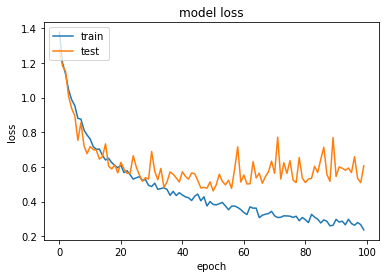

FileNotFoundError: ignored

In [14]:
x_train, x_val, y_train, y_val , datagen = dataSplit(images ,car_types_encoded_onehot)
model , fitted_model = train(model , datagen)
accuracyPlot(fitted_model)
errorPlot(fitted_model)


In [27]:
predicationClasses = predict(model=model)
foldersCreation()
savingFrames(predicationClasses)
statics()

Total number of each Class : Car = 9 , Bus = 21 and Truck = 0
